In [2]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


##Clustering current matrix by mutation profile <br>
Same notebook as before but using CV instead of OOB estimates

In [3]:
patient_mutations = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_mutations.csv', index_col=0)

In [268]:
patient_mutations.sum(axis=1).value_counts() / len(patient_mutations)

0     0.425406
1     0.358504
2     0.143966
3     0.048130
4     0.012562
5     0.005222
6     0.002117
7     0.000565
8     0.000565
12    0.000565
16    0.000423
15    0.000282
13    0.000282
9     0.000141
19    0.000141
17    0.000141
11    0.000141
21    0.000141
23    0.000141
10    0.000141
14    0.000141
22    0.000141
27    0.000141
dtype: float64

In [4]:
len(patient_mutations)

7085

Get frequency of each mutation in each tumor type

In [159]:
patient_tissues = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_tissues.csv', index_col=0)
print len(patient_tissues)

11175


In [160]:
patients_in_both = [x for x in patient_mutations.index if x in list(patient_tissues.Sample)]
print len(patients_in_both) 

7085


In [161]:
patient_tissues = patient_tissues[patient_tissues.Sample.isin(patients_in_both)]

In [162]:
ancestry = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/clinical/ancestory.csv', index_col=0)
white_patients = [x for x in list(ancestry[ancestry.race == 'WHITE'].index) if x in patients_in_both]
len(white_patients)

5146

In [163]:
patients_in_both = [x for x in patients_in_both if x in white_patients]
print len(patients_in_both)

5146


In [164]:
tissues = patient_tissues.Tissue.unique()
print tissues

['GBM' 'OV' 'LUAD' 'LUSC' 'PRAD' 'BLCA' 'TGCT' 'PAAD' 'KIRP' 'LIHC' 'MESO'
 'STAD' 'SKCM' 'THCA' 'COAD' 'HNSC' 'KIRC' 'BRCA' 'UCEC' 'READ' 'CESC'
 'LGG' 'DLBC' 'KICH' 'UCS' 'ACC' 'PCPG' 'UVM' 'LAML']


In [165]:
df = pd.DataFrame(np.nan, index=patient_mutations.columns, columns=[])
for tissue in tissues:
    patients_with_tissue = patient_tissues[patient_tissues.Tissue == tissue].Sample
    df[tissue] = patient_mutations.ix[patients_with_tissue].sum() / len(patients_with_tissue)

In [166]:
df = df[df.sum(axis=1) > 0.05]

In [167]:
df.shape

(83, 29)

In [52]:
groups = [['SKCM', 'THCA'],
          ['PAAD', 'COAD', 'READ', 'UCS', 'UCEC'],
          ['STAD', 'OV', 'GBM', 'LUSC', 'HNSC'],
          ['BLCA', 'CESC']]

In [235]:
group_assignments = {'G1': groups[0],
                     'G2': groups[1],
                     'G3': groups[2],
                     'G4': groups[3]}
cmap = sns.color_palette("Set2", 5)
color_assignemnts = {'G1': cmap[0],
                     'G2': cmap[1],
                     'G3': cmap[2],
                     'G4': cmap[3],
                     'Other': (255,255,255)}

In [258]:
group_labels = []
for i, x in enumerate(df.columns):
    for g in ['G1', 'G2', 'G3', 'G4']:
        if x in group_assignments[g]:
            group_labels.append(color_assignemnts[g])
    if len(group_labels) - 1 != i:
        group_labels.append('#FFFFFF')

In [259]:
group_labels

[(0.55432528607985565, 0.62711267120697922, 0.79595541393055635),
 (0.55432528607985565, 0.62711267120697922, 0.79595541393055635),
 '#FFFFFF',
 (0.55432528607985565, 0.62711267120697922, 0.79595541393055635),
 '#FFFFFF',
 (0.90311419262605563, 0.54185316071790801, 0.76495195557089413),
 '#FFFFFF',
 (0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
 '#FFFFFF',
 '#FFFFFF',
 '#FFFFFF',
 (0.55432528607985565, 0.62711267120697922, 0.79595541393055635),
 (0.40000000596046448, 0.7607843279838562, 0.64705884456634521),
 (0.40000000596046448, 0.7607843279838562, 0.64705884456634521),
 (0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
 (0.55432528607985565, 0.62711267120697922, 0.79595541393055635),
 '#FFFFFF',
 '#FFFFFF',
 (0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
 (0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
 (0.90311419262605563, 0.54185316071790801, 0.76495195557089413),
 '#FFFFFF',
 '#FFFFFF',
 '#FFFFFF',
 (0.98131487

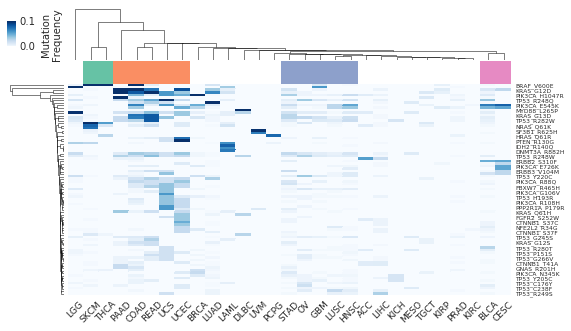

In [261]:
cm = sns.clustermap(df, cmap='Blues', vmax=0.1, 
                    cbar_kws={"ticks":[0,0.1], 'label': 'Mutation\nFrequency'},
                   col_colors = [group_labels])
hm = cm.ax_heatmap.get_position()
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=9, rotation=45)

width_stretch=1
hieght_stretch=0.5
scale_dendogram=0.5

cm.ax_heatmap.set_position([hm.x0, hm.y0+0.3, hm.width*width_stretch, hm.height*hieght_stretch])
col = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*width_stretch, col.height*scale_dendogram])
row = cm.ax_row_dendrogram.get_position()
cm.ax_row_dendrogram.set_position([row.x0+0.075, row.y0+0.3, row.width*scale_dendogram, row.height*hieght_stretch])
cm.cax.set_position([.2, 0.77, .012, .035])

plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/mhc_diversity/tissue.clustering.pdf')

### Heatmap for OOB accuracy for individual tumors

In [17]:
patient_tissues.index = patient_tissues.Sample

In [97]:
precision, recall, AUC, F1, tissues_used = [], [], [], [], []
for tissue in tissues:
    group = [tissue]
    
    # format labels
    def is_tissue(x):
        if x in group:
            return 1
        else:
            return 0
    patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)    
    
    tissue_patients = list(patient_tissues[patient_tissues.Tissue == tissue].index)
    if len([x for x in tissue_patients if x in patients_in_both]) < 100:
        continue
    
    # Train predictor
    X = patient_mutations.ix[patients_in_both].as_matrix()
    Y = patient_tissues.ix[patients_in_both].is_tissue
    
    skf = StratifiedKFold(n_splits=5)
    positives, negatives = [], []
    positives_prob, negatives_prob = [], []
    for train, test in skf.split(X, Y):
        try: 
            weight_shift = float(len(Y[train][Y[train] == 0]))/len(Y[train][Y[train] == 1])
            clf = RandomForestClassifier(random_state=0, class_weight={1:weight_shift, 0:1})
            clf.fit(X[train], Y[train])
            df = pd.DataFrame(X[test])
            df['positive'] = list(Y[test].astype(bool))
            positives.extend(clf.predict(df[df['positive']].ix[:, :1018].as_matrix()))
            negatives.extend(clf.predict(df[~df['positive']].ix[:, :1018].as_matrix()))
            positives_prob.extend(clf.predict_proba(df[df['positive']].ix[:, :1018].as_matrix()))
            negatives_prob.extend(clf.predict_proba(df[~df['positive']].ix[:, :1018].as_matrix()))
        except:
            print "Poorly divided patients"
    if (sum(positives)+sum(negatives)) == 0:
        precision.append(0)
    else:
        precision.append(float(sum(positives))/(sum(positives)+sum(negatives)))
    recall.append(float(sum(positives))/len(positives))
    AUC.append(metrics.roc_auc_score([1 for x in positives_prob] + [0 for x in negatives_prob], 
                                     [x[1] for x in positives_prob] + [x[1] for x in negatives_prob]))
    F1.append(metrics.f1_score([1 for x in positives] + [0 for x in negatives], 
                               [x for x in positives] + [x for x in negatives]))
    tissues_used.append(tissue)

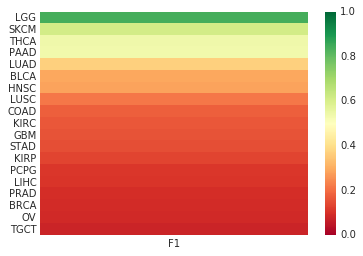

In [98]:
mutation_results = pd.DataFrame({'Tissue': tissues_used,
                        'Precision': precision,
                        'Recall': recall,
                        'AUC': AUC,
                        'F1': F1})
sns.heatmap(mutation_results.sort_values('F1', ascending=False)[['F1']], 
            yticklabels = mutation_results.sort_values('F1', ascending=False).Tissue,
               cmap='RdYlGn', vmax=1, vmin=0)

### Heatmap for CV-10 accuracy for grouped tumors

In [99]:
precision, recall, AUC, F1, tissues_used = [], [], [], [], []
for group in groups:
    
    # format labels
    def is_tissue(x):
        if x in group:
            return 1
        else:
            return 0
    patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)    
    
    tissue_patients = list(patient_tissues[patient_tissues.is_tissue == 1].index)
    if len([x for x in tissue_patients if x in patients_in_both]) < 100:
        continue
    
    # Train predictor
    X = patient_mutations.ix[patients_in_both].as_matrix()
    Y = patient_tissues.ix[patients_in_both].is_tissue
    
    skf = StratifiedKFold(n_splits=10)
    positives, negatives = [], []
    positives_prob, negatives_prob = [], []
    for train, test in skf.split(X, Y):
        weight_shift = float(len(Y[train][Y[train] == 0]))/len(Y[train][Y[train] == 1])
        clf = RandomForestClassifier(random_state=0, class_weight={1:weight_shift, 0:1})
        clf.fit(X[train], Y[train])
        df = pd.DataFrame(X[test])
        df['positive'] = list(Y[test].astype(bool))
        positives.extend(clf.predict(df[df['positive']].ix[:, :1018].as_matrix()))
        negatives.extend(clf.predict(df[~df['positive']].ix[:, :1018].as_matrix()))
        positives_prob.extend(clf.predict_proba(df[df['positive']].ix[:, :1018].as_matrix()))
        negatives_prob.extend(clf.predict_proba(df[~df['positive']].ix[:, :1018].as_matrix()))
    if (sum(positives)+sum(negatives)) == 0:
        precision.append(0)
    else:
        precision.append(float(sum(positives))/(sum(positives)+sum(negatives)))
    recall.append(float(sum(positives))/len(positives))
    AUC.append(metrics.roc_auc_score([1 for x in positives_prob] + [0 for x in negatives_prob], [x[1] for x in positives_prob] + [x[1] for x in negatives_prob]))
    F1.append(metrics.f1_score([1 for x in positives] + [0 for x in negatives], 
                               [x for x in positives] + [x for x in negatives]))
    tissues_used.append(group)

In [100]:
grouped_mutation_results = pd.DataFrame({'Tissue': tissues_used,
                        'Precision': precision,
                        'Recall': recall,
                        'AUC': AUC,
                        'F1': F1})

Visualized together

In [101]:
all_mutation_results = pd.concat([mutation_results, grouped_mutation_results])

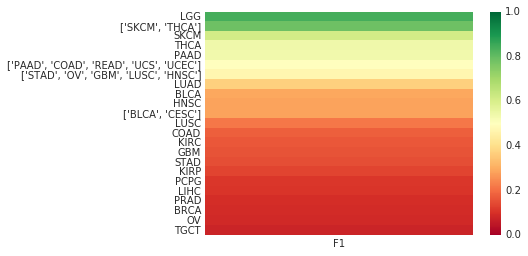

In [102]:
sns.heatmap(all_mutation_results.sort_values('F1', ascending=False)[['F1']], 
            yticklabels = all_mutation_results.sort_values('F1', ascending=False).Tissue,
               cmap='RdYlGn', vmax=1, vmin=0)

## Predicting from PHBR scores

In [103]:
classI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_i.csv', index_col=0)
classII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_ii.csv', index_col=0)
patient_PHBRs = pd.concat([pd.concat([classI.transpose(), classII.transpose()]).transpose()])

In [104]:
precision, recall, AUC, F1, tissues_used = [], [], [], [], []
for tissue in tissues:
    print tissue
    group = [tissue]
    
    # format labels
    def is_tissue(x):
        if x in group:
            return 1
        else:
            return 0
    patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)    
    tissue_patients = list(patient_tissues[patient_tissues.is_tissue == 1].index)
    if len([x for x in tissue_patients if x in patients_in_both]) < 100:
        continue
    
    # Train predictor
    X = patient_PHBRs.ix[patients_in_both].as_matrix()
    Y = patient_tissues.ix[patients_in_both].is_tissue
    
    skf = StratifiedKFold(n_splits=10)
    positives, negatives = [], []
    positives_prob, negatives_prob = [], []
    for train, test in skf.split(X, Y):
        weight_shift = float(len(Y[train][Y[train] == 0]))/len(Y[train][Y[train] == 1])
        clf = RandomForestClassifier(random_state=0, class_weight={1:weight_shift, 0:1})
        clf.fit(X[train], Y[train])
        df = pd.DataFrame(X[test])
        df['positive'] = list(Y[test].astype(bool))
        positives.extend(clf.predict(df[df['positive']].ix[:, :2036].as_matrix()))
        negatives.extend(clf.predict(df[~df['positive']].ix[:, :2036].as_matrix()))
        positives_prob.extend(clf.predict_proba(df[df['positive']].ix[:, :2036].as_matrix()))
        negatives_prob.extend(clf.predict_proba(df[~df['positive']].ix[:, :2036].as_matrix()))
    if (sum(positives)+sum(negatives)) == 0:
        precision.append(0)
    else:
        precision.append(float(sum(positives))/(sum(positives)+sum(negatives)))
    recall.append(float(sum(positives))/len(positives))
    AUC.append(metrics.roc_auc_score([1 for x in positives_prob] + [0 for x in negatives_prob],
                                     [x[1] for x in positives_prob] + [x[1] for x in negatives_prob]))
    F1.append(metrics.f1_score([1 for x in positives] + [0 for x in negatives], 
                               [x for x in positives] + [x for x in negatives]))
    tissues_used.append(tissue)

GBM
OV
LUAD
LUSC
PRAD
BLCA
TGCT
PAAD
KIRP
LIHC
MESO
STAD
SKCM
THCA
COAD
HNSC
KIRC
BRCA
UCEC
READ
CESC
LGG
DLBC
KICH
UCS
ACC
PCPG
UVM
LAML


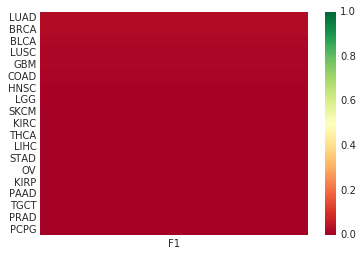

In [105]:
PHBR_results = pd.DataFrame({'Tissue': tissues_used,
                        'Precision': precision,
                        'Recall': recall,
                        'AUC': AUC,
                        'F1': F1})
sns.heatmap(PHBR_results.sort_values('F1', ascending=False)[['F1']], 
            yticklabels = PHBR_results.sort_values('F1', ascending=False).Tissue,
               cmap='RdYlGn', vmax=1, vmin=0)

In [106]:
precision, recall, AUC, F1, tissues_used = [], [], [], [], []
for group in groups:
    
    # format labels
    def is_tissue(x):
        if x in group:
            return 1
        else:
            return 0
    patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)    
    tissue_patients = list(patient_tissues[patient_tissues.is_tissue == 1].index)
    if len([x for x in tissue_patients if x in patients_in_both]) < 100:
        continue
        
    # Train predictor
    X = patient_PHBRs.ix[patients_in_both].as_matrix()
    Y = patient_tissues.ix[patients_in_both].is_tissue
    
    skf = StratifiedKFold(n_splits=10)
    positives, negatives = [], []
    positives_prob, negatives_prob = [], []
    for train, test in skf.split(X, Y):
        weight_shift = float(len(Y[train][Y[train] == 0]))/len(Y[train][Y[train] == 1])
        clf = RandomForestClassifier(random_state=0, class_weight={1:weight_shift, 0:1})
        clf.fit(X[train], Y[train])
        df = pd.DataFrame(X[test])
        df['positive'] = list(Y[test].astype(bool))
        positives.extend(clf.predict(df[df['positive']].ix[:, :2036].as_matrix()))
        negatives.extend(clf.predict(df[~df['positive']].ix[:, :2036].as_matrix()))
        positives_prob.extend(clf.predict_proba(df[df['positive']].ix[:, :2036].as_matrix()))
        negatives_prob.extend(clf.predict_proba(df[~df['positive']].ix[:, :2036].as_matrix()))
    if (sum(positives)+sum(negatives)) == 0:
        precision.append(0)
    else:
        precision.append(float(sum(positives))/(sum(positives)+sum(negatives)))
    recall.append(float(sum(positives))/len(positives))
    AUC.append(metrics.roc_auc_score([1 for x in positives_prob] + [0 for x in negatives_prob],
                                     [x[1] for x in positives_prob] + [x[1] for x in negatives_prob]))
    F1.append(metrics.f1_score([1 for x in positives] + [0 for x in negatives], 
                               [x for x in positives] + [x for x in negatives]))
    tissues_used.append(group)

In [107]:
grouped_PHBR_results = pd.DataFrame({'Tissue': tissues_used,
                        'Precision': precision,
                        'Recall': recall,
                        'AUC': AUC,
                        'F1': F1})

Visualize together

In [108]:
all_PHBR_results = pd.concat([PHBR_results, grouped_PHBR_results])

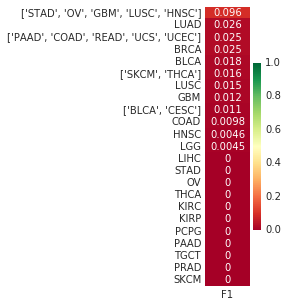

In [109]:
plt.figure(figsize=(1, 5))
sns.heatmap(all_PHBR_results.sort_values('F1', ascending=False)[['F1']], 
            yticklabels = all_PHBR_results.sort_values('F1', ascending=False).Tissue,
               cmap='RdYlGn', vmax=1, vmin=0, annot=True)

Visualize both together

In [110]:
def remove_brackets(x):
    if len(x[0]) > 1:
        return ','.join(x)
    else:
        return x
all_PHBR_results['Tissue_clean'] = all_PHBR_results.Tissue.apply(remove_brackets)
all_mutation_results['Tissue_clean'] = all_mutation_results.Tissue.apply(remove_brackets)

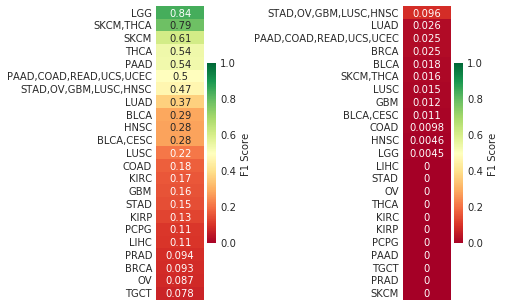

In [265]:
plt.figure(figsize=(7, 4.5))
ax1 = plt.subplot2grid((1, 2), (0, 0))

sns.heatmap(all_mutation_results.sort_values('F1', ascending=False)[['F1']], 
            yticklabels = all_mutation_results.sort_values('F1', ascending=False).Tissue_clean,
               cmap='RdYlGn', vmax=1, vmin=0, annot=True, xticklabels='',
            cbar_kws={'label': 'F1 Score'}, ax=ax1)
plt.tight_layout()

ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.heatmap(all_PHBR_results.sort_values('F1', ascending=False)[['F1']], 
            yticklabels = all_PHBR_results.sort_values('F1', ascending=False).Tissue_clean,
               cmap='RdYlGn', vmax=1, vmin=0, annot=True, xticklabels='',
            cbar_kws={'label': 'F1 Score'}, ax=ax2)
plt.tight_layout()
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/mhc_diversity/tissue.f1_scores.pdf')

## Precision-recall for specific tissue types

In [62]:
random_line = float(len(Y[train][Y[train] == 1]))/len(Y[train][Y[train] == 0])
print random_line

0.070471349353


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


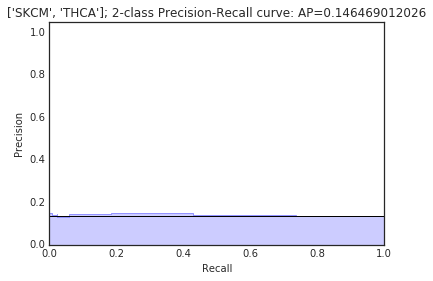

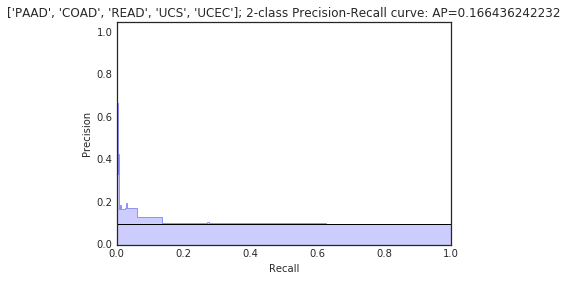

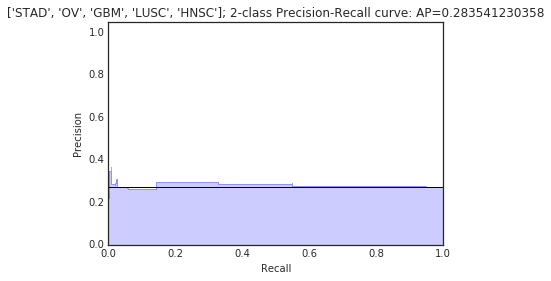

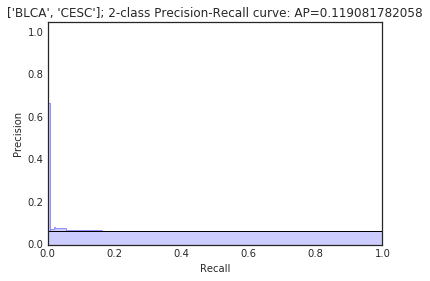

In [64]:
for group in groups:

    def is_tissue(x):
        if x in group:
            return 1
        else:
            return 0
    patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)    

    # Train predictor
    X = patient_PHBRs.ix[patients_in_both].as_matrix()
    Y = patient_tissues.ix[patients_in_both].is_tissue

    skf = StratifiedKFold(n_splits=10)
    all_randoms = []
    positives, negatives = [], []
    positives_prob, negatives_prob = [], []
    for train, test in skf.split(X, Y):
        all_randoms.append(float(len(Y[train][Y[train] == 1]))/len(Y[train][Y[train] == 0]))
        weight_shift = float(len(Y[train][Y[train] == 0]))/len(Y[train][Y[train] == 1])
        clf = RandomForestClassifier(random_state=0, class_weight={1:weight_shift, 0:1})
        clf.fit(X[train], Y[train])
        df = pd.DataFrame(X[test])
        df['positive'] = list(Y[test].astype(bool))
        positives.extend(clf.predict(df[df['positive']].ix[:, :2036].as_matrix()))
        negatives.extend(clf.predict(df[~df['positive']].ix[:, :2036].as_matrix()))
        positives_prob.extend(clf.predict_proba(df[df['positive']].ix[:, :2036].as_matrix()))
        negatives_prob.extend(clf.predict_proba(df[~df['positive']].ix[:, :2036].as_matrix()))
    
    precision, recall, thresholds = metrics.precision_recall_curve([1 for x in positives_prob] + [0 for x in negatives_prob], [x[1] for x in positives_prob] + [x[1] for x in negatives_prob])

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.axhline(len(positives)/float(len(positives_prob)+len(negatives_prob)), c='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('{0}; 2-class Precision-Recall curve: AP={1}'.format(
                group, np.mean(precision)))
    plt.show()
    plt.clf()

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


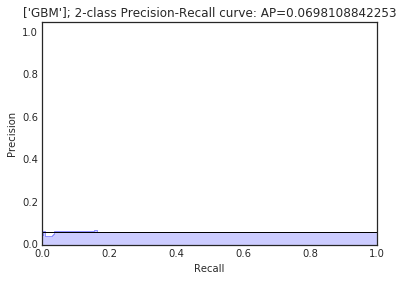

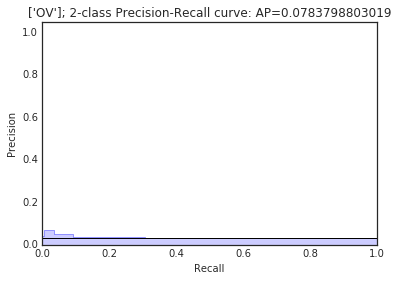

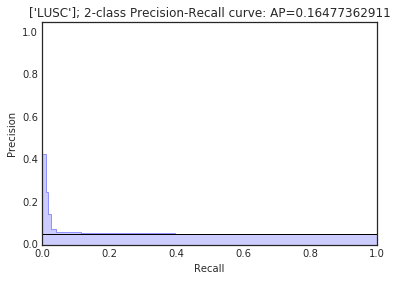

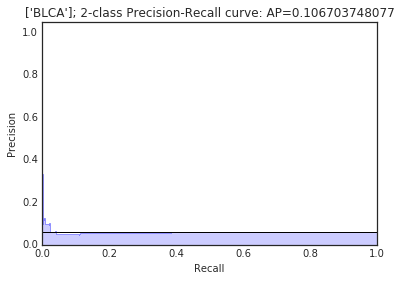

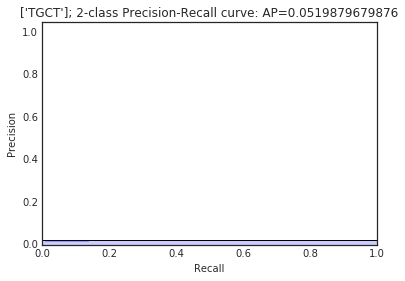

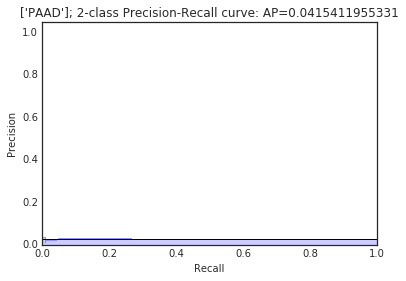

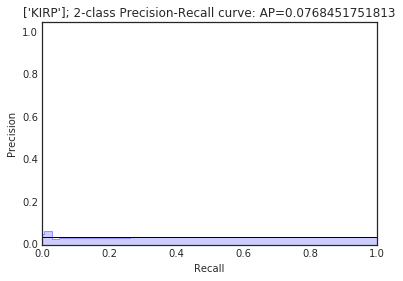

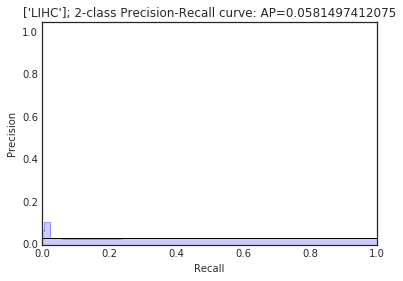

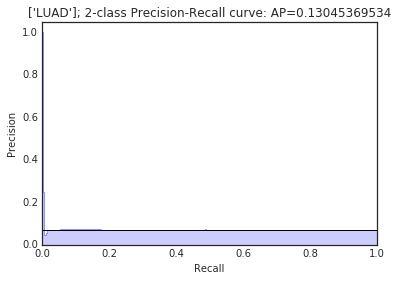

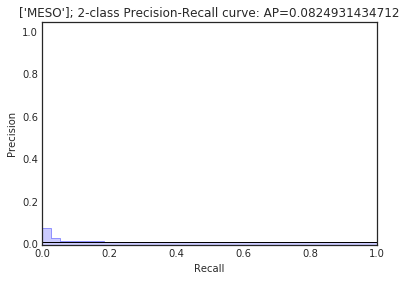

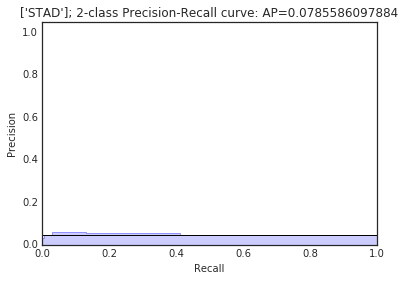

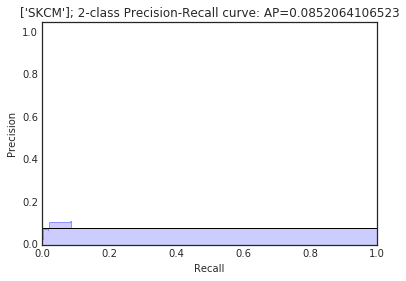

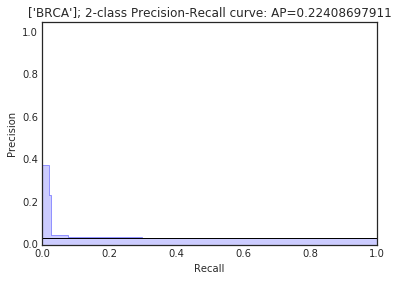

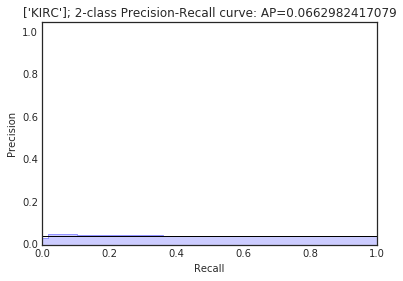

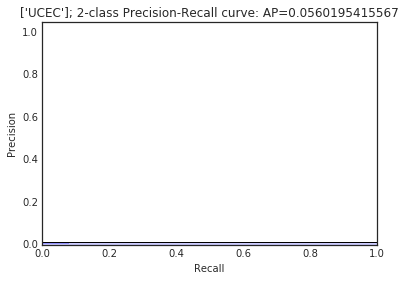

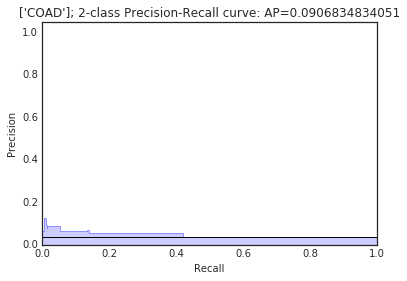

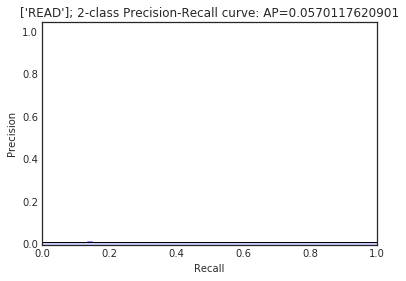

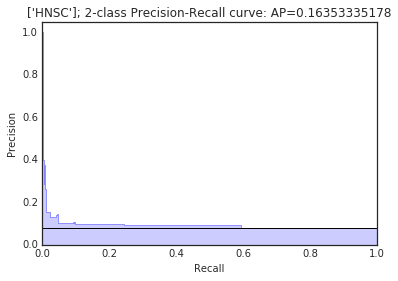

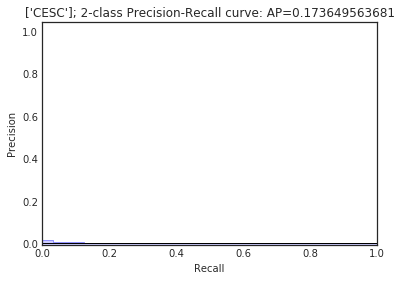

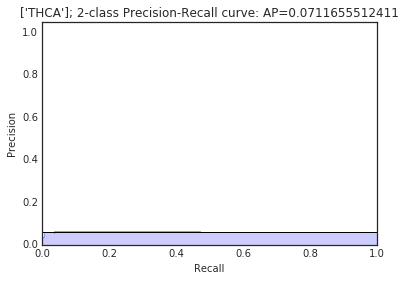

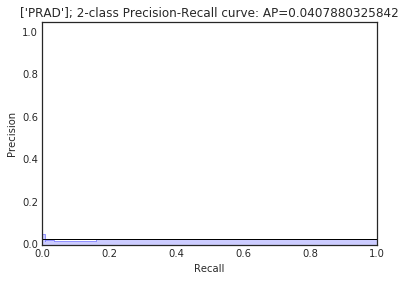

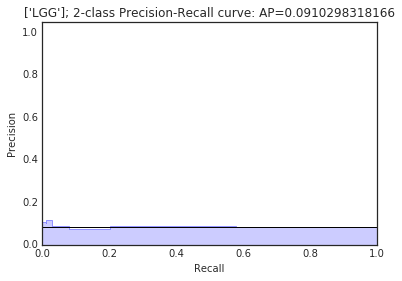

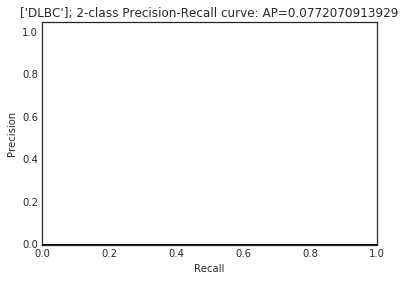

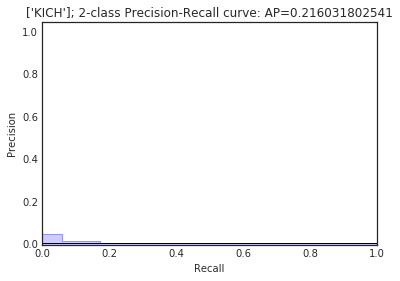

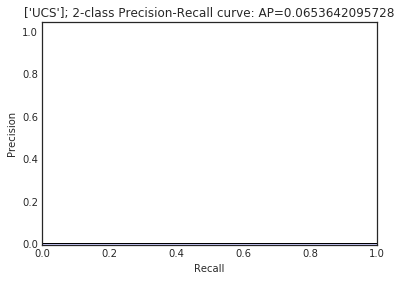

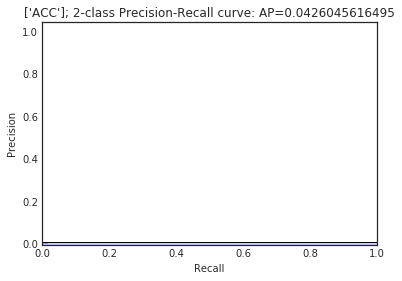

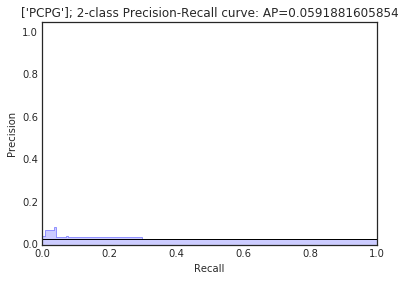

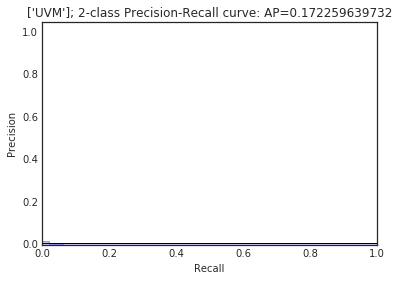

In [66]:
for tissue in tissues:

    group = [tissue]
    
    def is_tissue(x):
        if x in group:
            return 1
        else:
            return 0
    patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)    

    # Train predictor
    X = patient_PHBRs.ix[patients_in_both].as_matrix()
    Y = patient_tissues.ix[patients_in_both].is_tissue

    skf = StratifiedKFold(n_splits=10, shuffle=True)
    all_randoms = []
    positives, negatives = [], []
    positives_prob, negatives_prob = [], []
    for train, test in skf.split(X, Y):
        all_randoms.append(float(len(Y[train][Y[train] == 1]))/len(Y[train][Y[train] == 0]))
        weight_shift = float(len(Y[train][Y[train] == 0]))/len(Y[train][Y[train] == 1])
        clf = RandomForestClassifier(random_state=0, class_weight={1:weight_shift, 0:1})
        clf.fit(X[train], Y[train])
        df = pd.DataFrame(X[test])
        df['positive'] = list(Y[test].astype(bool))
        positives.extend(clf.predict(df[df['positive']].ix[:, :2036].as_matrix()))
        negatives.extend(clf.predict(df[~df['positive']].ix[:, :2036].as_matrix()))
        positives_prob.extend(clf.predict_proba(df[df['positive']].ix[:, :2036].as_matrix()))
        negatives_prob.extend(clf.predict_proba(df[~df['positive']].ix[:, :2036].as_matrix()))
    
    precision, recall, thresholds = metrics.precision_recall_curve([1 for x in positives_prob] + [0 for x in negatives_prob], [x[1] for x in positives_prob] + [x[1] for x in negatives_prob])

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.axhline(len(positives)/float(len(positives_prob)+len(negatives_prob)), c='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('{0}; 2-class Precision-Recall curve: AP={1}'.format(
                group, np.mean(precision)))
    plt.show()
    plt.clf()

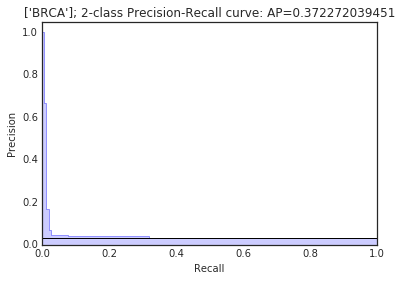

,Precision,Recall
0,0.030509,1.000000
1,0.040193,0.318471
2,0.045283,0.076433
3,0.067797,0.025478
4,0.166667,0.019108
5,0.333333,0.012739
6,0.666667,0.012739
7,1.000000,0.006369
8,1.000000,0.000000


In [18]:
group = ['BRCA']

def is_tissue(x):
    if x in group:
        return 1
    else:
        return 0
patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)    

# Train predictor
X = patient_PHBRs.ix[patients_in_both].as_matrix()
Y = patient_tissues.ix[patients_in_both].is_tissue

skf = StratifiedKFold(n_splits=10)
all_randoms = []
positives, negatives = [], []
positives_prob, negatives_prob = [], []
for train, test in skf.split(X, Y):
    all_randoms.append(float(len(Y[train][Y[train] == 1]))/len(Y[train][Y[train] == 0]))
    weight_shift = float(len(Y[train][Y[train] == 0]))/len(Y[train][Y[train] == 1])
    clf = RandomForestClassifier(random_state=0, class_weight={1:weight_shift, 0:1})
    clf.fit(X[train], Y[train])
    df = pd.DataFrame(X[test])
    df['positive'] = list(Y[test].astype(bool))
    positives.extend(clf.predict(df[df['positive']].ix[:, :2036].as_matrix()))
    negatives.extend(clf.predict(df[~df['positive']].ix[:, :2036].as_matrix()))
    positives_prob.extend(clf.predict_proba(df[df['positive']].ix[:, :2036].as_matrix()))
    negatives_prob.extend(clf.predict_proba(df[~df['positive']].ix[:, :2036].as_matrix()))

precision, recall, thresholds = metrics.precision_recall_curve([1 for x in positives_prob] + [0 for x in negatives_prob], [x[1] for x in positives_prob] + [x[1] for x in negatives_prob])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.axhline(np.mean(all_randoms), c='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('{0}; 2-class Precision-Recall curve: AP={1}'.format(
            group, np.mean(precision)))
plt.show()
plt.clf()
df = pd.DataFrame({'Precision': precision,
                   'Recall': recall})
df

In [21]:
pd.Series(clf.feature_importances_).max()

0.013705898429627722

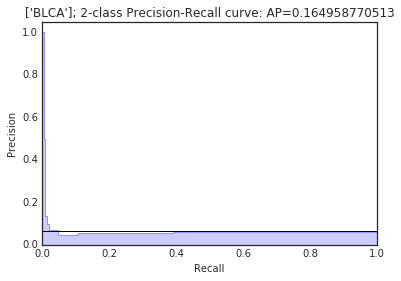

,Precision,Recall
0,0.059464,1.000000
1,0.055249,0.392157
2,0.055300,0.392157
3,0.055325,0.392157
4,0.055351,0.392157
5,0.055376,0.392157
6,0.055402,0.392157
7,0.055504,0.392157
8,0.055607,0.392157
9,0.055633,0.392157


In [17]:
group = ['BLCA']

def is_tissue(x):
    if x in group:
        return 1
    else:
        return 0
patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)    

# Train predictor
X = patient_PHBRs.ix[patients_in_both].as_matrix()
Y = patient_tissues.ix[patients_in_both].is_tissue

skf = StratifiedKFold(n_splits=10)
all_randoms = []
positives, negatives = [], []
positives_prob, negatives_prob = [], []
for train, test in skf.split(X, Y):
    all_randoms.append(float(len(Y[train][Y[train] == 1]))/len(Y[train][Y[train] == 0]))
    weight_shift = float(len(Y[train][Y[train] == 0]))/len(Y[train][Y[train] == 1])
    clf = RandomForestClassifier(random_state=0, class_weight={1:weight_shift, 0:1})
    clf.fit(X[train], Y[train])
    df = pd.DataFrame(X[test])
    df['positive'] = list(Y[test].astype(bool))
    positives.extend(clf.predict(df[df['positive']].ix[:, :2036].as_matrix()))
    negatives.extend(clf.predict(df[~df['positive']].ix[:, :2036].as_matrix()))
    positives_prob.extend(clf.predict_proba(df[df['positive']].ix[:, :2036].as_matrix()))
    negatives_prob.extend(clf.predict_proba(df[~df['positive']].ix[:, :2036].as_matrix()))

precision, recall, thresholds = metrics.precision_recall_curve([1 for x in positives_prob] + [0 for x in negatives_prob], [x[1] for x in positives_prob] + [x[1] for x in negatives_prob])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.axhline(np.mean(all_randoms), c='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('{0}; 2-class Precision-Recall curve: AP={1}'.format(
            group, np.mean(precision)))
plt.show()
plt.clf()
df = pd.DataFrame({'Precision': precision,
                   'Recall': recall})
df

In [64]:
len(patient_tissues[patient_tissues.Tissue == 'BRCA']) * 0.006

1.434